In [41]:
using Mamba, BenchmarkTools

# Test 1: Parameter Estimation

$ g(x;\theta) = \theta_1 + \theta_2 \sin(\theta_3\pi x) $

$f(\theta) = \big[ g(x_1,\theta), g(x_2,\theta) \big]^T $


In [30]:
g = (x,θ) -> θ[1] + θ[2]*exp(θ[3]*x)
x = [-0.5; 0.5]
y = [-1; 2]
dgdθ = (x,θ) -> [1; exp(θ[3]*x); θ[2]*exp(θ[3]*x)*x ]

function ff!(θ::AbstractVector, jac::AbstractMatrix)
    if length(jac) > 0
        # fill up the Jacobian matrix
        jac[1,:] = dgdθ(x[1],θ)
        jac[2,:] = dgdθ(x[2],θ)
    end
    
    return [g(x[1],θ); g(x[2],θ)]
end

ff! (generic function with 1 method)

### Using RTO

In [3]:
include("../RandomizeThenOptimize.jl")
using RandomizeThenOptimize

In [31]:
n = 3
p = Problem(n,2)
forward_model!(p,ff!)
obs_σ!(p,[0.3,0.3]);
obs_data!(p,y);

In [32]:
nsamps = 10000;

In [33]:
chain = rto_mcmc(p,nsamps);
b = @benchmark rto_mcmc(p,nsamps)
tseconds = mean(b).time / 1e9

3.148498727

In [34]:
sim = Chains(nsamps,n,names=[string("θ_",i) for i = 1:n]);
sim[:,:,1] = chain;

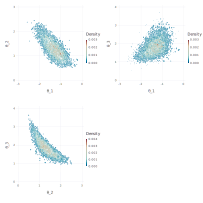

In [35]:
plt = Mamba.plot(sim[:,:,1],:contour,legend=true);
draw(plt,nrow=2,ncol=2)

In [9]:
ESS = summarystats(sim).value[1,end,1]
ESSpertime = ESS / tseconds

1531.5297724869145

### Using MALA

In [10]:
nsamps_mala = nsamps*10;
sim_mala = Chains(nsamps_mala,n,names=[string("θ_",i) for i = 1:n]);
θ_mala = MALAVariate(zeros(n), 0.01, x->logpostgrad(x,p));

In [12]:
sample!(θ_mala);

b = @benchmark for i in 1:nsamps_mala
    sample!(θ_mala)
    sim_mala[i, :, 1] = θ_mala;
end
tseconds = mean(b).time / 1e9

1.995501672

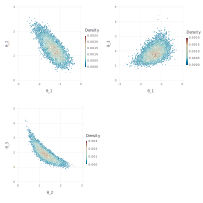

In [13]:
plt = Mamba.plot(sim_mala[1:10:end,:,1],:contour,legend=true);
draw(plt, nrow=2,ncol=2)

In [14]:
ESS = summarystats(sim_mala).value[1,end,1]
ESSpertime = ESS/tseconds

900.1534168710372

### Using HMC

In [36]:
sim_hmc = Chains(nsamps,n,names=[string("θ_",i) for i = 1:n]);
θ_hmc = HMCVariate(zeros(n), 0.01, 50, x->logpostgrad(x,p));

In [37]:
sample!(θ_hmc)

b = @benchmark for i in 1:nsamps
    sample!(θ_hmc)
    sim_hmc[i, :, 1] = θ_hmc;
end
tseconds = mean(b).time / 1e9

3.981243239

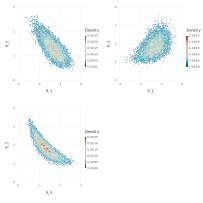

In [38]:
plt = Mamba.plot(sim_hmc[:,:,1],:contour,legend=true);
draw(plt, nrow=2,ncol=2 )

In [40]:
ESS = summarystats(sim_hmc).value[1,end,1]
ESSpertime = ESS/tseconds

525.4508924293608